## Before meeting with Sijie of Sept 9

In [1]:
# # Install the latest version of author's repo neural ode implementation
# !git clone https://github.com/rtqichen/torchdiffeq.git
# !cd torchdiffeq && pip install -e .
# !ls torchdiffeq/torchdiffeq

In [13]:
# importing libraries
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from torchdiffeq import odeint, odeint_adjoint
from stockDataTransformer import stockDataTransformer

# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)

# Total Data Size
data_size = data.shape[0]

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

median_data = get_median(data)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))

# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, 4).values
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = ['week(t-4)', 'week(t-3)', 'week(t-2)', 'week(t-1)', 'week(t)']).head(20))

(506, 1)
   median_stockprice_week
0                6.522572
1                6.432569
2                6.384427
3                6.225123
4                5.997283
5                6.049106
6                6.187098
7                6.240301
8                6.642778
9                6.888709
(502, 5)
    week(t-4)  week(t-3)  week(t-2)  week(t-1)   week(t)
0    6.522572   6.432569   6.384427   6.225123  5.997283
1    6.432569   6.384427   6.225123   5.997283  6.049106
2    6.384427   6.225123   5.997283   6.049106  6.187098
3    6.225123   5.997283   6.049106   6.187098  6.240301
4    5.997283   6.049106   6.187098   6.240301  6.642778
5    6.049106   6.187098   6.240301   6.642778  6.888709
6    6.187098   6.240301   6.642778   6.888709  6.890396
7    6.240301   6.642778   6.888709   6.890396  7.080826
8    6.642778   6.888709   6.890396   7.080826  7.292260
9    6.888709   6.890396   7.080826   7.292260  7.421818
10   6.890396   7.080826   7.292260   7.421818  7.603969
11   7.08082

In [14]:
# size of the data
data_size = data_m1.shape[0]
dim_input = data_m1.shape[1]
# batch time and batch size
batch_time = 6  # time steps ahead that we need to predict, for each training sample
train_size = int(0.8*data_size)  # training size
print(f"training size is {train_size}")
test_size = data_size - train_size
print(f"test size is {test_size}")

test_freq = 50
viz = True

training size is 401
test size is 101


In [15]:
# Convert to tensor
# https://pytorch.org/docs/stable/generated/torch.from_numpy.html
data_torch = torch.from_numpy(data_m1)  # https://pytorch.org/docs/stable/generated/torch.from_numpy.html
# true_y.shape
# Reshape it to get in (m, 1, dim_input)
data_torch = torch.reshape(data_torch, (data_size, 1, dim_input))  # https://pytorch.org/docs/stable/generated/torch.reshape.html
print(data_torch.shape)

# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0., test_size-batch_time, test_size-batch_time)
print(t.shape)

# # Initial value
# true_y0 = torch.reshape(true_y[0:batch_size], (batch_size, 1, dim))
# # true_y0


torch.Size([502, 1, 5])
torch.Size([95])


In [16]:
def get_batch(mode):
    if mode == 'train':
        # Get mini batches
        s = torch.arange(0, train_size-batch_time)  # https://pytorch.org/docs/stable/generated/torch.arange.html
        # Get the #s initial values from data 
        batch_y0 = data_torch[s]  # (M, D): m = number of examples, D = dimension
        # The time steps ahead for each sample
        batch_t = t[:batch_time]  # (T)
        # For each initial value, we will have T values 
        batch_y = torch.stack([data_torch[s + i] for i in range(0, batch_time)], dim=0)  # (T, M, D)
        # batch_y = torch.reshape(batch_y, (batch_time, batch_size, 1, 1))
        return batch_y0, batch_t, batch_y
    elif mode == 'test':
        s = torch.arange(train_size, data_size-batch_time)
        # Get the #s initial values from data 
        batch_y0 = data_torch[s]  # (M, D): m = number of examples, D = dimension
        # The time steps ahead for each sample
        batch_t = t[:batch_time]  # (T)
        # For each initial value, we will have T values 
        batch_y = torch.stack([data_torch[s + i] for i in range(0, batch_time)], dim=0)  # (T, M, D)
        # batch_y = torch.reshape(batch_y, (batch_time, batch_size, 1, 1))
    
        return batch_y0, batch_t, batch_y

In [18]:
train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
print(train_batch_y0.shape)
print(train_batch_t.shape)
print(train_batch_y.shape)

torch.Size([395, 1, 5])
torch.Size([6])
torch.Size([6, 395, 1, 5])


In [6]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(dim_input, 150),
            nn.Tanh(),
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, dim_input),
        )
        self.net = self.net.double()
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
# func = ODEFunc()

# def visualize(t, true_y, pred_y, odefunc, itr):
  
#     if viz:
      
#         plt.figure()
#         plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], 'g-')
#         plt.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--')
#         # plt.savefig(DATA_TYPE + '/ts' + str(itr) + '.png')
#         plt.show()
        
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [11]:
def train_5(optimizer_str, loss_str, niters = niters, print_loss = print_loss):
    if optimizer_str == 'rmsprop':
        optimizer = optim.RMSprop(func.parameters(), lr = lr)
    elif optimizer_str == 'adam':
        optimizer = optim.Adam(func.parameters(), lr=1e-3)
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
        pred_y = odeint(func, train_batch_y0, train_batch_t)
        # print(pred_y.shape)
        # loss = torch.mean(torch.abs(pred_y - batch_y))
        if loss_str == 'mse':
            loss = torch.nn.MSELoss()(pred_y, train_batch_y)  # https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-1-6e439b27117e
        loss.backward()
        optimizer.step()
        if print_loss:
            if itr%200==0:
                with torch.no_grad():
                    print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))


    
def train_loss():
    train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
    train_pred_y = odeint(func, train_batch_y0, train_batch_t)
    loss = torch.nn.MSELoss()(train_pred_y[batch_time-1, :, :, :], train_batch_y[batch_time-1, :, :, :])
    with torch.no_grad():
        print('Total Train Loss {:.6f}'.format(loss.item()))
    return train_batch_y, train_pred_y
    

def test_loss():
    test_batch_y0, test_batch_t, test_batch_y = get_batch('test')
    test_pred_y = odeint(func, test_batch_y0, test_batch_t)
    loss = torch.nn.MSELoss()(test_pred_y[batch_time-1, :, :, :], test_batch_y[batch_time-1, :, :, :])
    with torch.no_grad():
        print('Total Test Loss {:.6f}'.format(loss.item()))
    return test_batch_y, test_pred_y

def plot_test(i, test_batch_y, test_pred_y):
    t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
    plt.figure()
    plt.plot(t.numpy(), test_batch_y.numpy()[batch_time-1, :, 0, i], 'g', label = f"orig_week{i+batch_time}")
    plt.plot(t.numpy(), test_pred_y.detach().numpy()[batch_time-1, :, 0, i], '--', label = f"pred_week{i+batch_time}")
    plt.title(f"Test: Apple's Median Stock price for week{i+batch_time}")
    plt.legend(framealpha=1, frameon=True);
    plt.show()
def plot_train(i, train_batch_y, train_pred_y):
    t = torch.linspace(1., train_size-batch_time, train_size-batch_time)
    plt.figure()
    plt.plot(t.numpy(), train_batch_y.numpy()[batch_time-1, :, 0, i], 'g', label = f"orig_week{i+batch_time}")
    plt.plot(t.numpy(), train_pred_y.detach().numpy()[batch_time-1, :, 0, i], '--', label = f"pred_week{i+batch_time}")
    plt.title(f"Train: Apple's Median Stock price for week{i+batch_time}")
    plt.legend(framealpha=1, frameon=True);
    plt.show()


Iter 0200 | Total Loss 0.542613
Iter 0400 | Total Loss 0.512804
Iter 0600 | Total Loss 0.501462
Iter 0800 | Total Loss 0.492385
Iter 1000 | Total Loss 0.487030
Iter 1200 | Total Loss 0.482392
Iter 1400 | Total Loss 0.477741
Iter 1600 | Total Loss 0.463314
Iter 1800 | Total Loss 0.449630
Iter 2000 | Total Loss 0.434746
Total Train Loss 1.126645
Total Test Loss 12.357962


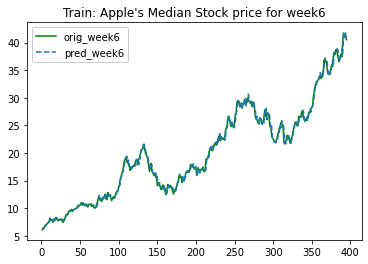

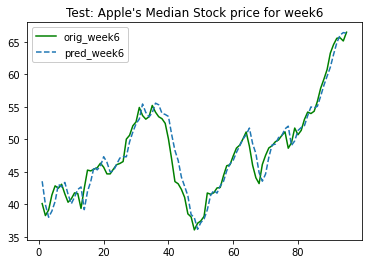

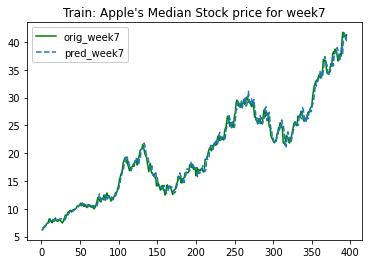

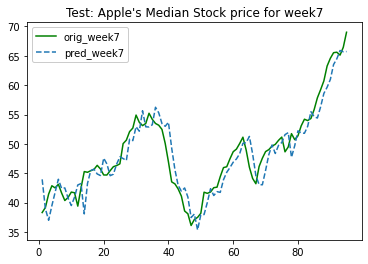

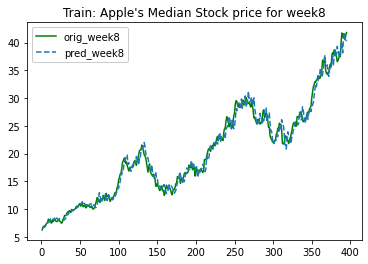

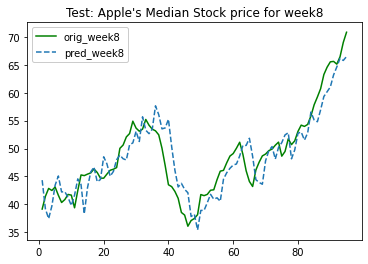

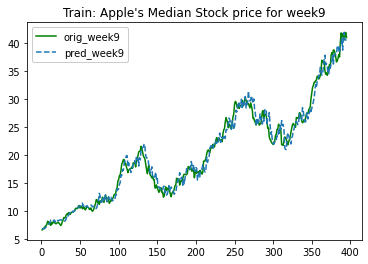

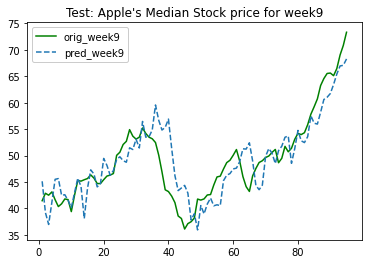

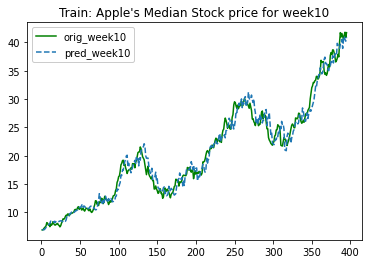

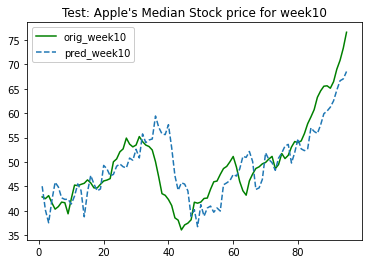

In [12]:
func = ODEFunc()
lr = 1e-3
optimizer_str = 'adam'
niters = 2000  # training epochs
loss_str = 'mse'
print_loss = True
train(optimizer_str, loss_str, niters, print_loss = print_loss)
train_batch_y, train_pred_y = train_loss()
test_batch_y, test_pred_y = test_loss()
for i in range(5):
    plot_train(i, train_batch_y, train_pred_y)
    plot_test(i, test_batch_y, test_pred_y)

## After meeting with Sijie on Sept 9

(506, 1)
   median_stockprice_week
0                6.522572
1                6.432569
2                6.384427
3                6.225123
4                5.997283
5                6.049106
6                6.187098
7                6.240301
8                6.642778
9                6.888709
(497, 10)
    week i+1  week i+2  week i+3  week i+4  week i+5  week i+6  week i+7  \
0   6.522572  6.432569  6.384427  6.225123  5.997283  6.049106  6.187098   
1   6.432569  6.384427  6.225123  5.997283  6.049106  6.187098  6.240301   
2   6.384427  6.225123  5.997283  6.049106  6.187098  6.240301  6.642778   
3   6.225123  5.997283  6.049106  6.187098  6.240301  6.642778  6.888709   
4   5.997283  6.049106  6.187098  6.240301  6.642778  6.888709  6.890396   
5   6.049106  6.187098  6.240301  6.642778  6.888709  6.890396  7.080826   
6   6.187098  6.240301  6.642778  6.888709  6.890396  7.080826  7.292260   
7   6.240301  6.642778  6.888709  6.890396  7.080826  7.292260  7.421818   
8   6.64277

/home/mehta.omkar/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 397, 1, 5])) that is different to the input size (torch.Size([397, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mehta.omkar/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 100, 1, 5])) that is different to the input size (torch.Size([100, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


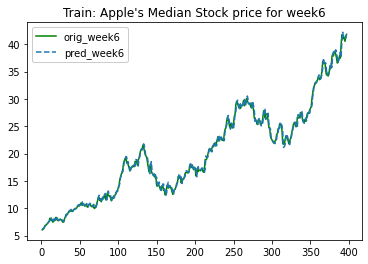

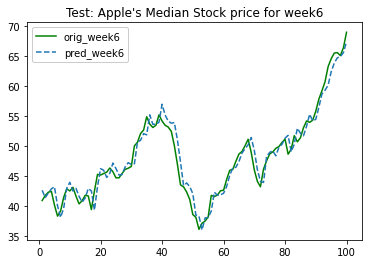

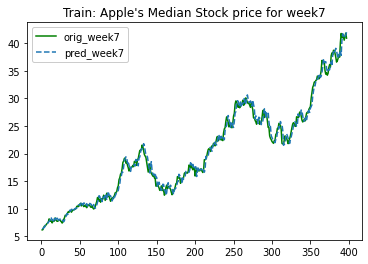

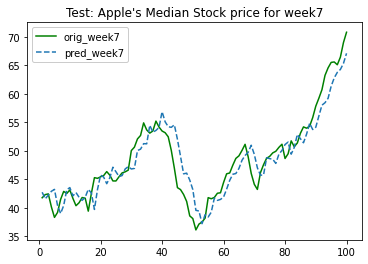

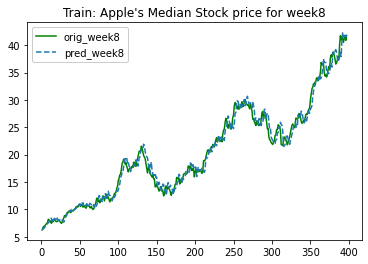

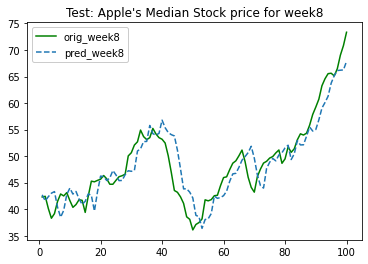

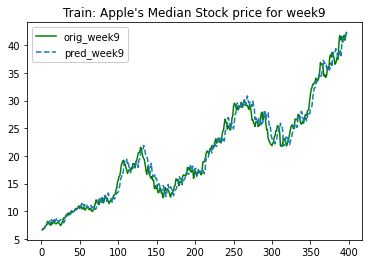

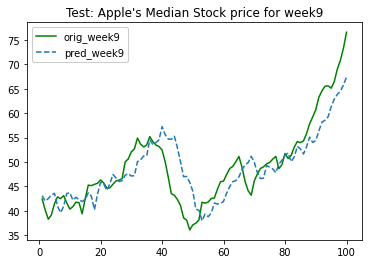

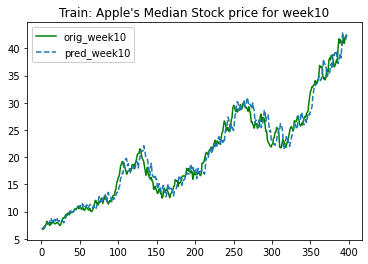

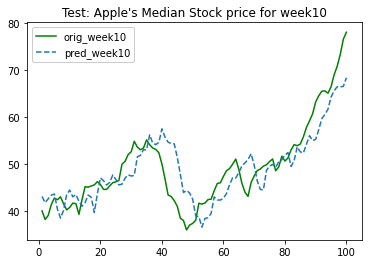

    train_actual  train_predictions
0       6.049106           6.189428
1       6.187098           6.259245
2       6.240301           6.424435
3       6.642778           6.469061
4       6.888709           6.846210
5       6.890396           7.077000
6       7.080826           7.037449
7       7.292260           7.200441
8       7.421818           7.429920
9       7.603969           7.559306
10      8.183534           7.723282
11      8.063482           8.346210
12      7.753154           8.171393
13      7.802984           7.785378
14      7.458158           7.843709
15      7.980841           7.543995
16      7.703169           8.137742
17      7.906170           7.810183
18      8.347130           8.026074
19      7.985592           8.474669
    train_actual  train_predictions
0       6.187098           6.370724
1       6.240301           6.438303
2       6.642778           6.599724
3       6.888709           6.644976
4       6.890396           7.015106
5       7.080826           7

In [87]:
# Trial 1
# importing libraries
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from torchdiffeq import odeint, odeint_adjoint
from stockDataTransformer import stockDataTransformer

# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)

# # Total Data Size
# data_size = data.shape[0]

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

median_data = get_median(data)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
lag = 5
forecast = 5
# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]).head(20))

def split_data(perc_train, perc_valid, lag, data_m1, n_features):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train = values[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test = values[len_train:, :]  # [len_valid+len_train:, :]
    n_features = n_features
    
    # split into input and outputs
    n_obs = lag * n_features
    train_X, train_y = train[:, :n_obs], train[:, n_obs:]
    test_X, test_y = test[:, :n_obs], test[:, n_obs:]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    dataload = {
        'train': train,
        'test': test,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features': n_features,
        'n_obs': n_obs,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y
    }
    
    return dataload

dataload = split_data(0.8, 0, 5, data_m1, 1)

train_X = torch.from_numpy(dataload['train_X'])
print(train_X.shape)
train_y = torch.from_numpy(dataload['train_y'])
print(train_y.shape)
train_y = torch.reshape(train_y, (1, train_X.shape[0], 1, train_y.shape[1]))
print(train_y.shape)

test_X = torch.from_numpy(dataload['test_X'])
print(test_X.shape)
test_y = torch.from_numpy(dataload['test_y'])
print(test_y.shape)
test_y = torch.reshape(test_y, (1, test_X.shape[0], 1, test_y.shape[1]))
print(test_y.shape)


# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0., 100, 100)
print(t.shape)

class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(lag, 150),
            nn.Tanh(),
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, forecast),
        )
        self.net = self.net.double()
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

def train_general(optimizer_str, loss_str, niters, print_loss):
    if optimizer_str == 'rmsprop':
        optimizer = optim.RMSprop(func.parameters(), lr = lr)
    elif optimizer_str == 'adam':
        optimizer = optim.Adam(func.parameters(), lr=1e-3)
    loss_list = []
    for itr in range(1, niters + 1):
        # https://discuss.pytorch.org/t/plotting-loss-curve/42632
        running_loss = 0.0
        
        optimizer.zero_grad()
        
        pred_y_all_states = odeint(func, train_X, t)
        # print(pred_y_all_states.shape)
        pred_y = pred_y_all_states[-1, :, :, :]
        pred_y = torch.reshape(pred_y, (1, pred_y.shape[0], pred_y.shape[1], pred_y.shape[2]))
        # print(pred_y.shape)
        assert(pred_y.shape == train_y.shape)
        # print(pred_y.shape)
        # loss = torch.mean(torch.abs(pred_y - batch_y))
        if loss_str == 'mse':
            loss = torch.nn.MSELoss(reduction='mean')(pred_y, train_y)  # https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-1-6e439b27117e
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if print_loss:
            if itr%200==0:
                with torch.no_grad():
                    print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
    return loss_list

def train_loss():
    train_pred_y = odeint(func, train_X, t)
    loss = torch.nn.MSELoss()(train_pred_y[-1, :, :, :], train_y)
    with torch.no_grad():
        print('Total Train Loss {:.6f}'.format(loss.item()))
    return train_pred_y

def test_loss():
    test_pred_y = odeint(func, test_X, t)
    loss = torch.nn.MSELoss()(test_pred_y[-1, :, :, :], test_y)
    with torch.no_grad():
        print('Total Test Loss {:.6f}'.format(loss.item()))
    return test_pred_y

def plot_test(i, test_y, test_pred_y):
    t = torch.linspace(1., test_y.shape[1], test_y.shape[1])
    plt.figure()
    plt.plot(t.numpy(), test_y.numpy()[-1, :, 0, i-1], 'g', label = f"orig_week{i+lag}")
    plt.plot(t.numpy(), test_pred_y.detach().numpy()[-1, :, 0, i-1], '--', label = f"pred_week{i+lag}")
    plt.title(f"Test: Apple's Median Stock price for week{i+lag}")
    plt.legend(framealpha=1, frameon=True);
    plt.show()

def plot_train(i, train_y, train_pred_y):
    t = torch.linspace(1., train_y.shape[1], train_y.shape[1])
    plt.figure()
    plt.plot(t.numpy(), train_y.numpy()[-1, :, 0, i-1], 'g', label = f"orig_week{i+lag}")
    plt.plot(t.numpy(), train_pred_y.detach().numpy()[-1, :, 0, i-1], '--', label = f"pred_week{i+lag}")
    plt.title(f"Train: Apple's Median Stock price for week{i+lag}")
    plt.legend(framealpha=1, frameon=True);
    plt.show()

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title('Train Loss')
    plt.ylabel('MSE Loss')
    plt.xlabel('Epochs')
func = ODEFunc()
lr = 1e-3
optimizer_str = 'adam'
niters = 2000  # training epochs
loss_str = 'mse'
print_loss = True
loss_list = train_general(optimizer_str, loss_str, niters, print_loss)

train_pred_y = train_loss()
test_pred_y = test_loss()
for i in range(1, 6):
    plot_train(i, train_y, train_pred_y)
    plot_test(i, test_y, test_pred_y)
    
data_w6 = {'train_actual': train_y.numpy()[-1,:, 0, 0],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 0]}
w6_data_df = pd.DataFrame(data_w6)

data_w7 = {'train_actual': train_y.numpy()[-1,:, 0, 1],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 1]}
w7_data_df = pd.DataFrame(data_w7)

data_w8 = {'train_actual': train_y.numpy()[-1,:, 0, 2],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 2]}
w8_data_df = pd.DataFrame(data_w8)

data_w9 = {'train_actual': train_y.numpy()[-1,:, 0, 3],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 3]}
w9_data_df = pd.DataFrame(data_w9)

data_w10 = {'train_actual': train_y.numpy()[-1,:, 0, 4],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 4]}
w10_data_df = pd.DataFrame(data_w10)

print(w6_data_df.head(20))
print(w7_data_df.head(20))
print(w8_data_df.head(20))
print(w9_data_df.head(20))
print(w10_data_df.head(20))


Text(0.5, 0, 'Epochs')

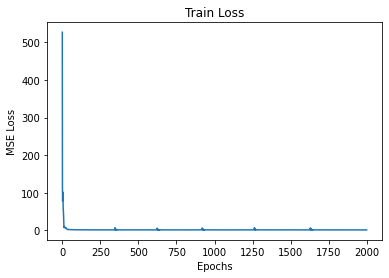

In [90]:
plt.plot(loss_list)
plt.title('Train Loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title('Train Loss')
    plt.ylabel('MSE Loss')
    plt.xlabel('Epochs')

(506, 1)
   median_stockprice_week
0                6.522572
1                6.432569
2                6.384427
3                6.225123
4                5.997283
5                6.049106
6                6.187098
7                6.240301
8                6.642778
9                6.888709
(497, 10)
    week i+1  week i+2  week i+3  week i+4  week i+5  week i+6  week i+7  \
0   6.522572  6.432569  6.384427  6.225123  5.997283  6.049106  6.187098   
1   6.432569  6.384427  6.225123  5.997283  6.049106  6.187098  6.240301   
2   6.384427  6.225123  5.997283  6.049106  6.187098  6.240301  6.642778   
3   6.225123  5.997283  6.049106  6.187098  6.240301  6.642778  6.888709   
4   5.997283  6.049106  6.187098  6.240301  6.642778  6.888709  6.890396   
5   6.049106  6.187098  6.240301  6.642778  6.888709  6.890396  7.080826   
6   6.187098  6.240301  6.642778  6.888709  6.890396  7.080826  7.292260   
7   6.240301  6.642778  6.888709  6.890396  7.080826  7.292260  7.421818   
8   6.64277

/home/mehta.omkar/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 397, 1, 5])) that is different to the input size (torch.Size([397, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mehta.omkar/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 100, 1, 5])) that is different to the input size (torch.Size([100, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Test Loss 13.835695


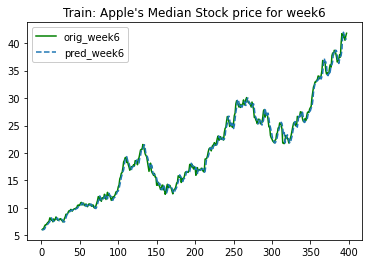

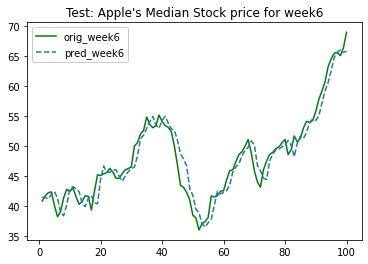

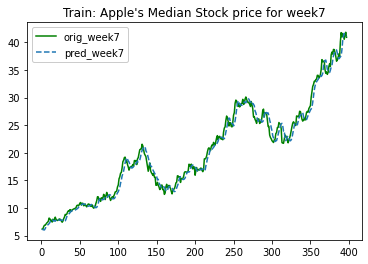

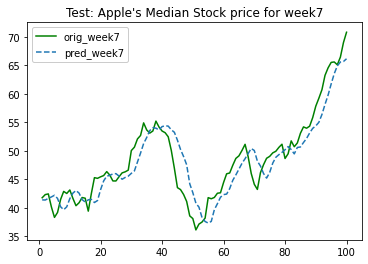

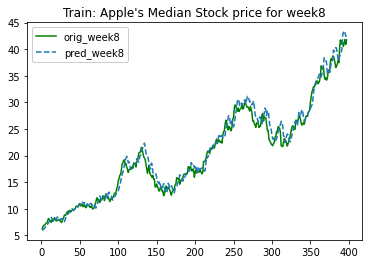

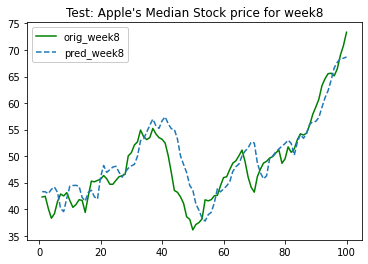

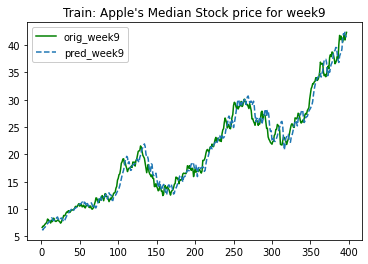

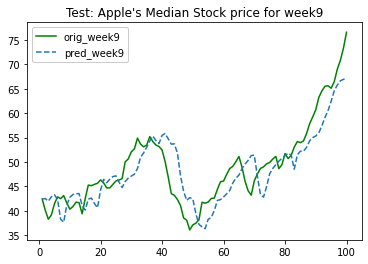

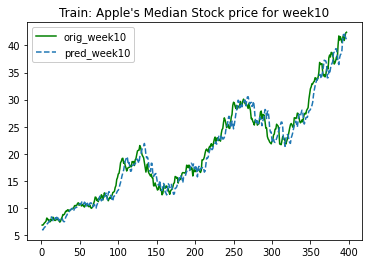

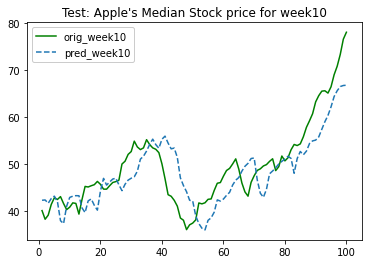

    train_actual  train_predictions
0       6.049106           6.059230
1       6.187098           5.983403
2       6.240301           6.048197
3       6.642778           6.113343
4       6.888709           6.386891
5       6.890396           6.781770
6       7.080826           6.910558
7       7.292260           6.972502
8       7.421818           7.150767
9       7.603969           7.327916
10      8.183534           7.493613
11      8.063482           7.899807
12      7.753154           8.190561
13      7.802984           7.953445
14      7.458158           7.645766
15      7.980841           7.565522
16      7.703169           7.619871
17      7.906170           7.791436
18      8.347130           7.795294
19      7.985592           8.104109
    train_actual  train_predictions
0       6.187098           6.164147
1       6.240301           6.090508
2       6.642778           6.051406
3       6.888709           6.038259
4       6.890396           6.287486
5       7.080826           6

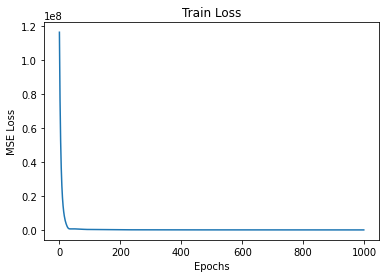

In [95]:

# Trial 1
# importing libraries
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from torchdiffeq import odeint, odeint_adjoint
from stockDataTransformer import stockDataTransformer

# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)

# # Total Data Size
# data_size = data.shape[0]

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

median_data = get_median(data)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
lag = 5
forecast = 5
# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]).head(20))

def split_data(perc_train, perc_valid, lag, data_m1, n_features):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train = values[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test = values[len_train:, :]  # [len_valid+len_train:, :]
    n_features = n_features
    
    # split into input and outputs
    n_obs = lag * n_features
    train_X, train_y = train[:, :n_obs], train[:, n_obs:]
    test_X, test_y = test[:, :n_obs], test[:, n_obs:]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    dataload = {
        'train': train,
        'test': test,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features': n_features,
        'n_obs': n_obs,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y
    }
    
    return dataload

dataload = split_data(0.8, 0, 5, data_m1, 1)

train_X = torch.from_numpy(dataload['train_X'])
print(train_X.shape)
train_y = torch.from_numpy(dataload['train_y'])
print(train_y.shape)
train_y = torch.reshape(train_y, (1, train_X.shape[0], 1, train_y.shape[1]))
print(train_y.shape)

test_X = torch.from_numpy(dataload['test_X'])
print(test_X.shape)
test_y = torch.from_numpy(dataload['test_y'])
print(test_y.shape)
test_y = torch.reshape(test_y, (1, test_X.shape[0], 1, test_y.shape[1]))
print(test_y.shape)


# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0., 100, 100)
print(t.shape)

class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(lag, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, forecast),
        )
        self.net = self.net.double()
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

def train_general(optimizer_str, loss_str, niters, print_loss):
    if optimizer_str == 'rmsprop':
        optimizer = optim.RMSprop(func.parameters(), lr = lr, weight_decay=lambda_l2)
    elif optimizer_str == 'adam':
        optimizer = optim.Adam(func.parameters(), lr=lr, weight_decay=lambda_l2)
    loss_list = []
    for itr in range(1, niters + 1):
        # https://discuss.pytorch.org/t/plotting-loss-curve/42632
        
        
        optimizer.zero_grad()
        
        pred_y_all_states = odeint(func, train_X, t)
        # print(pred_y_all_states.shape)
        pred_y = pred_y_all_states[-1, :, :, :]
        pred_y = torch.reshape(pred_y, (1, pred_y.shape[0], pred_y.shape[1], pred_y.shape[2]))
        # print(pred_y.shape)
        assert(pred_y.shape == train_y.shape)
        # print(pred_y.shape)
        # loss = torch.mean(torch.abs(pred_y - batch_y))
        if loss_str == 'mse':
            loss = torch.nn.MSELoss(reduction='sum')(pred_y, train_y)  # https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-1-6e439b27117e
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if print_loss:
            if itr%200==0:
                with torch.no_grad():
                    print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
    return loss_list

def train_loss():
    train_pred_y = odeint(func, train_X, t)
    loss = torch.nn.MSELoss()(train_pred_y[-1, :, :, :], train_y)
    with torch.no_grad():
        print('Total Train Loss {:.6f}'.format(loss.item()))
    return train_pred_y

def test_loss():
    test_pred_y = odeint(func, test_X, t)
    loss = torch.nn.MSELoss()(test_pred_y[-1, :, :, :], test_y)
    with torch.no_grad():
        print('Total Test Loss {:.6f}'.format(loss.item()))
    return test_pred_y

def plot_test(i, test_y, test_pred_y):
    t = torch.linspace(1., test_y.shape[1], test_y.shape[1])
    plt.figure()
    plt.plot(t.numpy(), test_y.numpy()[-1, :, 0, i-1], 'g', label = f"orig_week{i+lag}")
    plt.plot(t.numpy(), test_pred_y.detach().numpy()[-1, :, 0, i-1], '--', label = f"pred_week{i+lag}")
    plt.title(f"Test: Apple's Median Stock price for week{i+lag}")
    plt.legend(framealpha=1, frameon=True);
    plt.show()

def plot_train(i, train_y, train_pred_y):
    t = torch.linspace(1., train_y.shape[1], train_y.shape[1])
    plt.figure()
    plt.plot(t.numpy(), train_y.numpy()[-1, :, 0, i-1], 'g', label = f"orig_week{i+lag}")
    plt.plot(t.numpy(), train_pred_y.detach().numpy()[-1, :, 0, i-1], '--', label = f"pred_week{i+lag}")
    plt.title(f"Train: Apple's Median Stock price for week{i+lag}")
    plt.legend(framealpha=1, frameon=True);
    plt.show()

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title('Train Loss')
    plt.ylabel('MSE Loss')
    plt.xlabel('Epochs')
    plt.show()
    
trial = 1
func = ODEFunc()
lr = 1e-4
lambda_l2 = 1e-3
optimizer_str = 'adam'
niters = 1000  # training epochs
loss_str = 'mse'
print_loss = True
loss_list = train_general(optimizer_str, loss_str, niters, print_loss)

train_pred_y = train_loss()
test_pred_y = test_loss()
for i in range(1, 6):
    plot_train(i, train_y, train_pred_y)
    plot_test(i, test_y, test_pred_y)
    
data_w6 = {'train_actual': train_y.numpy()[-1,:, 0, 0],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 0]}
w6_data_df = pd.DataFrame(data_w6)

data_w7 = {'train_actual': train_y.numpy()[-1,:, 0, 1],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 1]}
w7_data_df = pd.DataFrame(data_w7)

data_w8 = {'train_actual': train_y.numpy()[-1,:, 0, 2],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 2]}
w8_data_df = pd.DataFrame(data_w8)

data_w9 = {'train_actual': train_y.numpy()[-1,:, 0, 3],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 3]}
w9_data_df = pd.DataFrame(data_w9)

data_w10 = {'train_actual': train_y.numpy()[-1,:, 0, 4],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 4]}
w10_data_df = pd.DataFrame(data_w10)

print(w6_data_df.head(20))
print(w7_data_df.head(20))
print(w8_data_df.head(20))
print(w9_data_df.head(20))
print(w10_data_df.head(20))

plot_loss(loss_list)

(506, 1)
   median_stockprice_week
0                6.522572
1                6.432569
2                6.384427
3                6.225123
4                5.997283
5                6.049106
6                6.187098
7                6.240301
8                6.642778
9                6.888709
(497, 10)
    week i+1  week i+2  week i+3  week i+4  week i+5  week i+6  week i+7  \
0   6.522572  6.432569  6.384427  6.225123  5.997283  6.049106  6.187098   
1   6.432569  6.384427  6.225123  5.997283  6.049106  6.187098  6.240301   
2   6.384427  6.225123  5.997283  6.049106  6.187098  6.240301  6.642778   
3   6.225123  5.997283  6.049106  6.187098  6.240301  6.642778  6.888709   
4   5.997283  6.049106  6.187098  6.240301  6.642778  6.888709  6.890396   
5   6.049106  6.187098  6.240301  6.642778  6.888709  6.890396  7.080826   
6   6.187098  6.240301  6.642778  6.888709  6.890396  7.080826  7.292260   
7   6.240301  6.642778  6.888709  6.890396  7.080826  7.292260  7.421818   
8   6.64277

/home/mehta.omkar/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 397, 1, 5])) that is different to the input size (torch.Size([397, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Train Loss 1.170203
Total Test Loss 3.455046


/home/mehta.omkar/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 100, 1, 5])) that is different to the input size (torch.Size([100, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


AttributeError: 'Text' object has no property 'dpi'

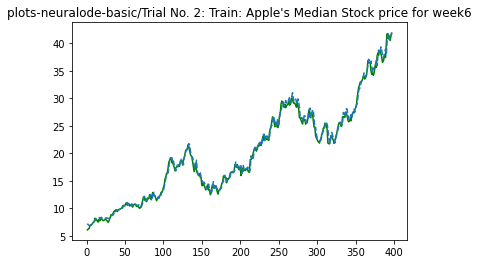

In [2]:
# Trial 2

# Trial 1
# importing libraries
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from torchdiffeq import odeint, odeint_adjoint
from stockDataTransformer import stockDataTransformer

# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)

# # Total Data Size
data_size = data.shape[0]

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

median_data = get_median(data)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
lag = 5
forecast = 5
# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]).head(20))

def split_data(perc_train, perc_valid, lag, data_m1, n_features):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train = values[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test = values[len_train:, :]  # [len_valid+len_train:, :]
    n_features = n_features
    
    # split into input and outputs
    n_obs = lag * n_features
    train_X, train_y = train[:, :n_obs], train[:, n_obs:]
    test_X, test_y = test[:, :n_obs], test[:, n_obs:]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    dataload = {
        'train': train,
        'test': test,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features': n_features,
        'n_obs': n_obs,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y
    }
    
    return dataload

dataload = split_data(0.8, 0, 5, data_m1, 1)

train_X = torch.from_numpy(dataload['train_X'])
print(train_X.shape)
train_y = torch.from_numpy(dataload['train_y'])
print(train_y.shape)
train_y = torch.reshape(train_y, (1, train_X.shape[0], 1, train_y.shape[1]))
print(train_y.shape)

test_X = torch.from_numpy(dataload['test_X'])
print(test_X.shape)
test_y = torch.from_numpy(dataload['test_y'])
print(test_y.shape)
test_y = torch.reshape(test_y, (1, test_X.shape[0], 1, test_y.shape[1]))
print(test_y.shape)


# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0., 100, 100)
print(t.shape)

# https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(lag, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, forecast),
        )
        self.net = self.net.double()
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

def train_general(optimizer_str, loss_str, niters, print_loss):
    if optimizer_str == 'rmsprop':
        optimizer = optim.RMSprop(func.parameters(), lr = lr, weight_decay=lambda_l2)
    elif optimizer_str == 'adam':
        optimizer = optim.Adam(func.parameters(), lr=lr, weight_decay=lambda_l2)
    loss_list = []
    for itr in range(1, niters + 1):
        # https://discuss.pytorch.org/t/plotting-loss-curve/42632
        optimizer.zero_grad()
        
        pred_y_all_states = odeint(func, train_X, t)
        # print(pred_y_all_states.shape)
        pred_y = pred_y_all_states[-1, :, :, :]
        pred_y = torch.reshape(pred_y, (1, pred_y.shape[0], pred_y.shape[1], pred_y.shape[2]))
        # print(pred_y.shape)
        assert(pred_y.shape == train_y.shape)
        # print(pred_y.shape)
        # loss = torch.mean(torch.abs(pred_y - batch_y))
        if loss_str == 'mse':
            loss = torch.nn.MSELoss()(pred_y, train_y)  # https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-1-6e439b27117e
        elif loss_str == 'rmse':
            rmse = RMSELoss()
            loss = rmse(pred_y, train_y)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if print_loss:
            if itr%200==0:
                with torch.no_grad():
                    print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
    return loss_list

def train_loss():
    train_pred_y = odeint(func, train_X, t)
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(train_pred_y[-1, :, :, :], train_y)
    loss = rmse(train_pred_y[-1, :, :, :], train_y)
    with torch.no_grad():
        print('Total Train Loss {:.6f}'.format(loss.item()))
    return train_pred_y

def test_loss():
    test_pred_y = odeint(func, test_X, t)
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(test_pred_y[-1, :, :, :], test_y)
    loss = rmse(test_pred_y[-1, :, :, :], test_y)
    with torch.no_grad():
        print('Total Test Loss {:.6f}'.format(loss.item()))
    return test_pred_y

def plot_test(i, test_y, test_pred_y):
    t = torch.linspace(1., test_y.shape[1], test_y.shape[1])
    plt.figure()
    plt.plot(t.numpy(), test_y.numpy()[-1, :, 0, i-1], 'g', label = f"orig_week{i+lag}")
    plt.plot(t.numpy(), test_pred_y.detach().numpy()[-1, :, 0, i-1], '--', label = f"pred_week{i+lag}")
    plt.title(f"Test: Apple's Median Stock price for week{i+lag}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-neuralode-basic/Trial No. {trial}: Test: Apple's Median Stock price for week{i+lag}.pdf", dpi = 150)
    plt.show()

def plot_train(i, train_y, train_pred_y):
    t = torch.linspace(1., train_y.shape[1], train_y.shape[1])
    plt.figure()
    plt.plot(t.numpy(), train_y.numpy()[-1, :, 0, i-1], 'g', label = f"orig_week{i+lag}")
    plt.plot(t.numpy(), train_pred_y.detach().numpy()[-1, :, 0, i-1], '--', label = f"pred_week{i+lag}")
    plt.title(f"Trial No. {trial}: Train: Apple's Median Stock price for week{i+lag}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-neuralode-basic/Trial No. {trial}: Train: Apple's Median Stock price for week{i+lag}.pdf", dpi = 150)
    plt.show()

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title('Train Loss')
    plt.ylabel('RMSE Loss')
    plt.xlabel('Epochs')
    plt.savefig(f"plots-neuralode-basic/Trial No. {trial}: RMSE Loss.pdf", dpi = 150)
    plt.show()
    
trial = 2
func = ODEFunc()
lr = 1e-3
lambda_l2 = 1e-3
optimizer_str = 'adam'
niters = 2000  # training epochs
loss_str = 'rmse'
print_loss = True
loss_list = train_general(optimizer_str, loss_str, niters, print_loss)
loss_list_trial_2 = pd.DataFrame(loss_list)
train_pred_y = train_loss()
test_pred_y = test_loss()
for i in range(1, 6):
    plot_train(i, train_y, train_pred_y)
    plot_test(i, test_y, test_pred_y)
    
data_w6 = {'train_actual': train_y.numpy()[-1,:, 0, 0],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 0]}
w6_data_df = pd.DataFrame(data_w6)

data_w7 = {'train_actual': train_y.numpy()[-1,:, 0, 1],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 1]}
w7_data_df = pd.DataFrame(data_w7)

data_w8 = {'train_actual': train_y.numpy()[-1,:, 0, 2],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 2]}
w8_data_df = pd.DataFrame(data_w8)

data_w9 = {'train_actual': train_y.numpy()[-1,:, 0, 3],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 3]}
w9_data_df = pd.DataFrame(data_w9)

data_w10 = {'train_actual': train_y.numpy()[-1,:, 0, 4],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 4]}
w10_data_df = pd.DataFrame(data_w10)

print(w6_data_df.head(20))
print(w7_data_df.head(20))
print(w8_data_df.head(20))
print(w9_data_df.head(20))
print(w10_data_df.head(20))

plot_loss(loss_list)

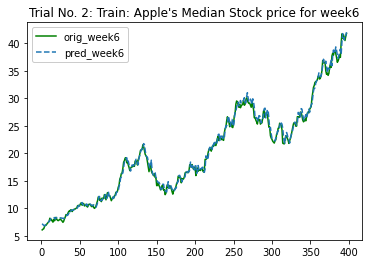

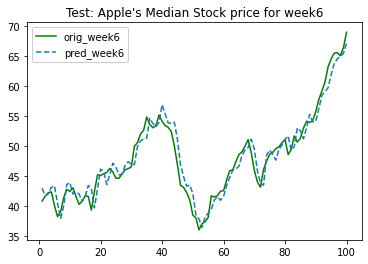

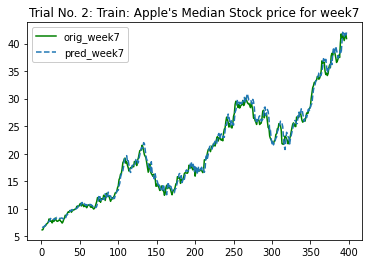

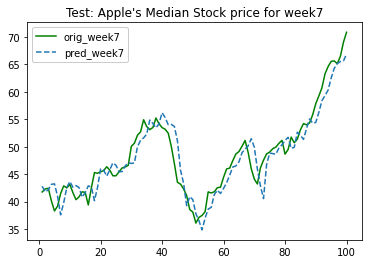

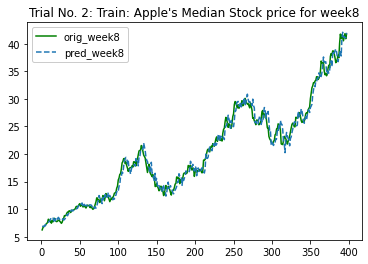

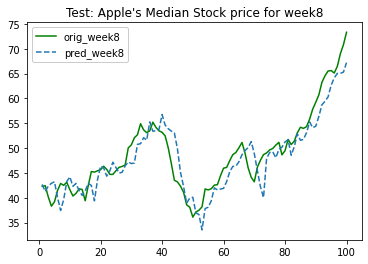

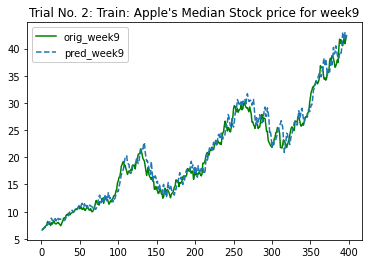

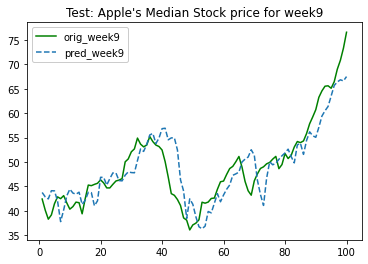

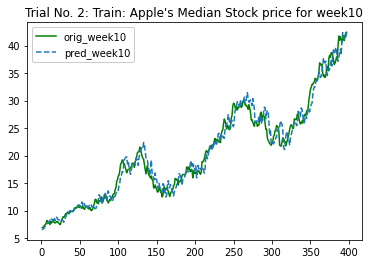

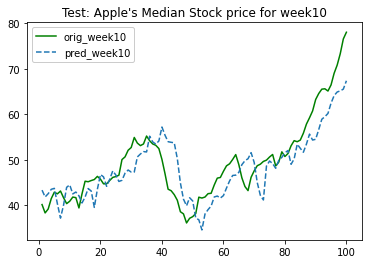

    train_actual  train_predictions
0       6.049106           7.184800
1       6.187098           7.012581
2       6.240301           6.889660
3       6.642778           6.796724
4       6.888709           6.915519
5       6.890396           7.005216
6       7.080826           7.124028
7       7.292260           7.244133
8       7.421818           7.449217
9       7.603969           7.609745
10      8.183534           7.713878
11      8.063482           8.083572
12      7.753154           8.105004
13      7.802984           8.145090
14      7.458158           8.170943
15      7.980841           8.237415
16      7.703169           8.304010
17      7.906170           8.005661
18      8.347130           8.221153
19      7.985592           8.282095
    train_actual  train_predictions
0       6.187098           6.743073
1       6.240301           6.664764
2       6.642778           6.741086
3       6.888709           6.814042
4       6.890396           6.986406
5       7.080826           7

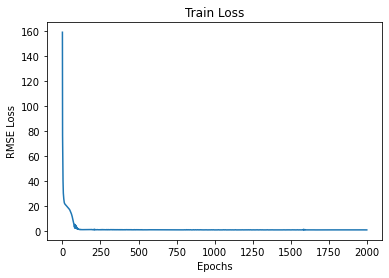

In [3]:
def plot_train(i, train_y, train_pred_y):
    t = torch.linspace(1., train_y.shape[1], train_y.shape[1])
    plt.figure()
    plt.plot(t.numpy(), train_y.numpy()[-1, :, 0, i-1], 'g', label = f"orig_week{i+lag}")
    plt.plot(t.numpy(), train_pred_y.detach().numpy()[-1, :, 0, i-1], '--', label = f"pred_week{i+lag}")
    plt.title(f"Trial No. {trial}: Train: Apple's Median Stock price for week{i+lag}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-neuralode-basic/Trial No. {trial}: Train: Apple's Median Stock price for week{i+lag}.pdf", dpi = 150)
    plt.show()
for i in range(1, 6):
    plot_train(i, train_y, train_pred_y)
    plot_test(i, test_y, test_pred_y)
    
data_w6 = {'train_actual': train_y.numpy()[-1,:, 0, 0],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 0]}
w6_data_df = pd.DataFrame(data_w6)

data_w7 = {'train_actual': train_y.numpy()[-1,:, 0, 1],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 1]}
w7_data_df = pd.DataFrame(data_w7)

data_w8 = {'train_actual': train_y.numpy()[-1,:, 0, 2],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 2]}
w8_data_df = pd.DataFrame(data_w8)

data_w9 = {'train_actual': train_y.numpy()[-1,:, 0, 3],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 3]}
w9_data_df = pd.DataFrame(data_w9)

data_w10 = {'train_actual': train_y.numpy()[-1,:, 0, 4],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 4]}
w10_data_df = pd.DataFrame(data_w10)

print(w6_data_df.head(20))
print(w7_data_df.head(20))
print(w8_data_df.head(20))
print(w9_data_df.head(20))
print(w10_data_df.head(20))

plot_loss(loss_list)

(506, 1)
   median_stockprice_week
0                6.522572
1                6.432569
2                6.384427
3                6.225123
4                5.997283
5                6.049106
6                6.187098
7                6.240301
8                6.642778
9                6.888709
(497, 10)
    week i+1  week i+2  week i+3  week i+4  week i+5  week i+6  week i+7  \
0   6.522572  6.432569  6.384427  6.225123  5.997283  6.049106  6.187098   
1   6.432569  6.384427  6.225123  5.997283  6.049106  6.187098  6.240301   
2   6.384427  6.225123  5.997283  6.049106  6.187098  6.240301  6.642778   
3   6.225123  5.997283  6.049106  6.187098  6.240301  6.642778  6.888709   
4   5.997283  6.049106  6.187098  6.240301  6.642778  6.888709  6.890396   
5   6.049106  6.187098  6.240301  6.642778  6.888709  6.890396  7.080826   
6   6.187098  6.240301  6.642778  6.888709  6.890396  7.080826  7.292260   
7   6.240301  6.642778  6.888709  6.890396  7.080826  7.292260  7.421818   
8   6.64277

/home/mehta.omkar/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 397, 1, 5])) that is different to the input size (torch.Size([397, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mehta.omkar/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 100, 1, 5])) that is different to the input size (torch.Size([100, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Train Loss 1.203803
Total Test Loss 3.498275


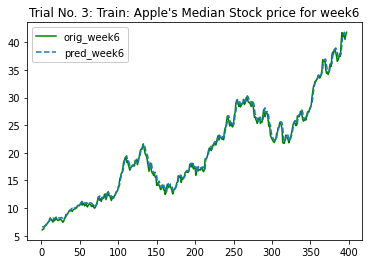

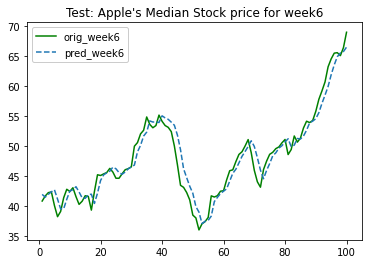

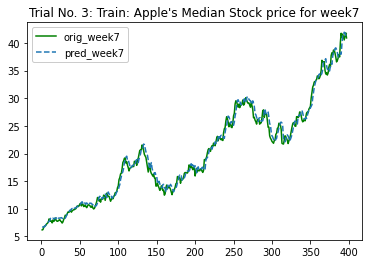

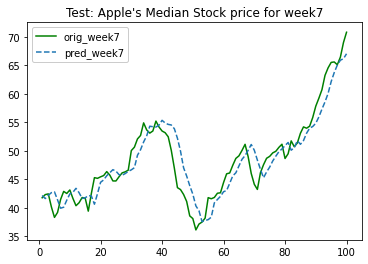

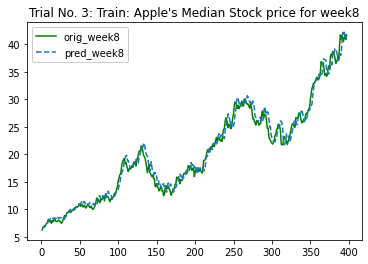

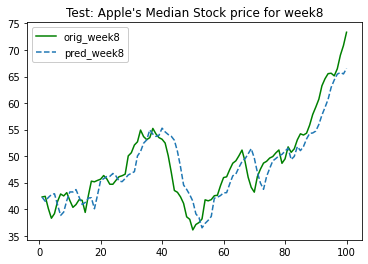

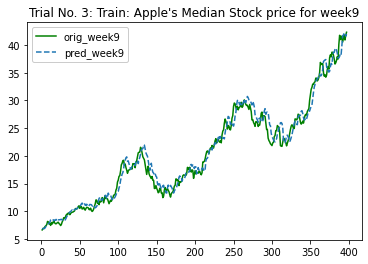

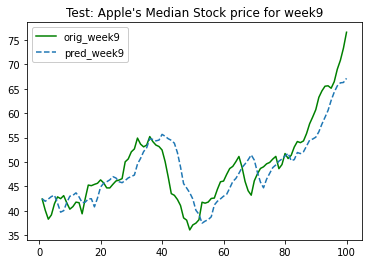

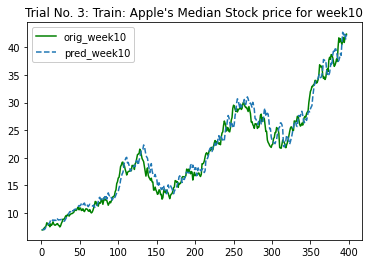

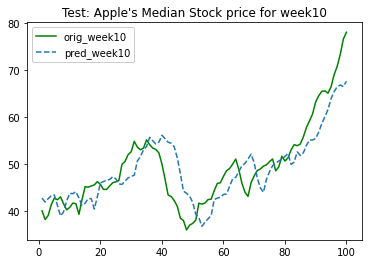

    train_actual  train_predictions
0       6.049106           6.667009
1       6.187098           6.624159
2       6.240301           6.648406
3       6.642778           6.643470
4       6.888709           6.824191
5       6.890396           7.052103
6       7.080826           7.132880
7       7.292260           7.305103
8       7.421818           7.517267
9       7.603969           7.644581
10      8.183534           7.801403
11      8.063482           8.198357
12      7.753154           8.296645
13      7.802984           8.141499
14      7.458158           8.205804
15      7.980841           8.046508
16      7.703169           8.186412
17      7.906170           8.145188
18      8.347130           8.139860
19      7.985592           8.491611
    train_actual  train_predictions
0       6.187098           6.756477
1       6.240301           6.713641
2       6.642778           6.737559
3       6.888709           6.730789
4       6.890396           6.915772
5       7.080826           7

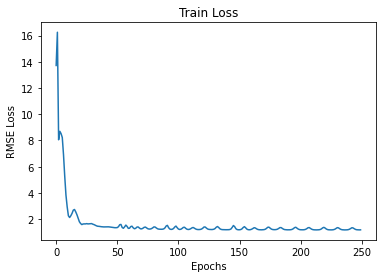

In [4]:
# Trial 3
# importing libraries
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from torchdiffeq import odeint, odeint_adjoint
from stockDataTransformer import stockDataTransformer

# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)

# # Total Data Size
data_size = data.shape[0]

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

median_data = get_median(data)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
lag = 5
forecast = 5
# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]).head(20))

def split_data(perc_train, perc_valid, lag, data_m1, n_features):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train = values[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test = values[len_train:, :]  # [len_valid+len_train:, :]
    n_features = n_features
    
    # split into input and outputs
    n_obs = lag * n_features
    train_X, train_y = train[:, :n_obs], train[:, n_obs:]
    test_X, test_y = test[:, :n_obs], test[:, n_obs:]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    dataload = {
        'train': train,
        'test': test,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features': n_features,
        'n_obs': n_obs,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y
    }
    
    return dataload

dataload = split_data(0.8, 0, 5, data_m1, 1)

train_X = torch.from_numpy(dataload['train_X'])
print(train_X.shape)
train_y = torch.from_numpy(dataload['train_y'])
print(train_y.shape)
train_y = torch.reshape(train_y, (1, train_X.shape[0], 1, train_y.shape[1]))
print(train_y.shape)

test_X = torch.from_numpy(dataload['test_X'])
print(test_X.shape)
test_y = torch.from_numpy(dataload['test_y'])
print(test_y.shape)
test_y = torch.reshape(test_y, (1, test_X.shape[0], 1, test_y.shape[1]))
print(test_y.shape)


# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0., 100, 100)
print(t.shape)

# https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(lag, 150),
            nn.Tanh(),
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, forecast),
        )
        self.net = self.net.double()
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

def train_general(optimizer_str, loss_str, niters, print_loss):
    if optimizer_str == 'rmsprop':
        optimizer = optim.RMSprop(func.parameters(), lr = lr)
    elif optimizer_str == 'adam':
        optimizer = optim.Adam(func.parameters(), lr=lr)
    loss_list = []
    rmse = RMSELoss()
    for itr in range(1, niters + 1):
        # https://discuss.pytorch.org/t/plotting-loss-curve/42632
        optimizer.zero_grad()
        
        pred_y_all_states = odeint(func, train_X, t)
        # print(pred_y_all_states.shape)
        pred_y = pred_y_all_states[-1, :, :, :]
        pred_y = torch.reshape(pred_y, (1, pred_y.shape[0], pred_y.shape[1], pred_y.shape[2]))
        # print(pred_y.shape)
        assert(pred_y.shape == train_y.shape)
        # print(pred_y.shape)
        # loss = torch.mean(torch.abs(pred_y - batch_y))
        if loss_str == 'mse':
            loss = torch.nn.MSELoss()(pred_y, train_y)  # https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-1-6e439b27117e
        elif loss_str == 'rmse':
            loss = rmse(pred_y, train_y)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if print_loss:
            if itr%200==0:
                with torch.no_grad():
                    print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
    return loss_list

def train_loss():
    train_pred_y = odeint(func, train_X, t)
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(train_pred_y[-1, :, :, :], train_y)
    loss = rmse(train_pred_y[-1, :, :, :], train_y)
    with torch.no_grad():
        print('Total Train Loss {:.6f}'.format(loss.item()))
    return train_pred_y

def test_loss():
    test_pred_y = odeint(func, test_X, t)
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(test_pred_y[-1, :, :, :], test_y)
    loss = rmse(test_pred_y[-1, :, :, :], test_y)
    with torch.no_grad():
        print('Total Test Loss {:.6f}'.format(loss.item()))
    return test_pred_y

def plot_test(i, test_y, test_pred_y):
    t = torch.linspace(1., test_y.shape[1], test_y.shape[1])
    plt.figure()
    plt.plot(t.numpy(), test_y.numpy()[-1, :, 0, i-1], 'g', label = f"orig_week{i+lag}")
    plt.plot(t.numpy(), test_pred_y.detach().numpy()[-1, :, 0, i-1], '--', label = f"pred_week{i+lag}")
    plt.title(f"Test: Apple's Median Stock price for week{i+lag}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-neuralode-basic/Trial No. {trial}: Test: Apple's Median Stock price for week{i+lag}.pdf", dpi = 150)
    plt.show()

def plot_train(i, train_y, train_pred_y):
    t = torch.linspace(1., train_y.shape[1], train_y.shape[1])
    plt.figure()
    plt.plot(t.numpy(), train_y.numpy()[-1, :, 0, i-1], 'g', label = f"orig_week{i+lag}")
    plt.plot(t.numpy(), train_pred_y.detach().numpy()[-1, :, 0, i-1], '--', label = f"pred_week{i+lag}")
    plt.title(f"Trial No. {trial}: Train: Apple's Median Stock price for week{i+lag}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-neuralode-basic/Trial No. {trial}: Train: Apple's Median Stock price for week{i+lag}.pdf", dpi = 150)
    plt.show()

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title('Train Loss')
    plt.ylabel('RMSE Loss')
    plt.xlabel('Epochs')
    plt.savefig(f"plots-neuralode-basic/Trial No. {trial}: RMSE Loss.pdf", dpi = 150)
    plt.show()
    
trial = 3
func = ODEFunc()
lr = 1e-3
# lambda_l2 = 1e-3
optimizer_str = 'adam'
niters = 250  # training epochs
loss_str = 'rmse'
print_loss = True
loss_list = train_general(optimizer_str, loss_str, niters, print_loss)
loss_list_trial_2 = pd.DataFrame(loss_list)
train_pred_y = train_loss()
test_pred_y = test_loss()
for i in range(1, 6):
    plot_train(i, train_y, train_pred_y)
    plot_test(i, test_y, test_pred_y)
    
data_w6 = {'train_actual': train_y.numpy()[-1,:, 0, 0],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 0]}
w6_data_df = pd.DataFrame(data_w6)

data_w7 = {'train_actual': train_y.numpy()[-1,:, 0, 1],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 1]}
w7_data_df = pd.DataFrame(data_w7)

data_w8 = {'train_actual': train_y.numpy()[-1,:, 0, 2],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 2]}
w8_data_df = pd.DataFrame(data_w8)

data_w9 = {'train_actual': train_y.numpy()[-1,:, 0, 3],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 3]}
w9_data_df = pd.DataFrame(data_w9)

data_w10 = {'train_actual': train_y.numpy()[-1,:, 0, 4],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 4]}
w10_data_df = pd.DataFrame(data_w10)

print(w6_data_df.head(20))
print(w7_data_df.head(20))
print(w8_data_df.head(20))
print(w9_data_df.head(20))
print(w10_data_df.head(20))

plot_loss(loss_list)

In [ ]:
# Trial 4
# importing libraries
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from torchdiffeq import odeint, odeint_adjoint
from stockDataTransformer import stockDataTransformer

# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)

# # Total Data Size
data_size = data.shape[0]

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

median_data = get_median(data)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
lag = 5
forecast = 5
# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]).head(20))

def split_data(perc_train, perc_valid, lag, data_m1, n_features):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    len_valid = int(perc_valid*sizeOfReframed)
    train = values[:len_train, :]
    valid = values[len_train:len_valid+len_train, :]
    test = values[len_valid+len_train:, :]
    n_features = n_features
    
    # split into input and outputs
    n_obs = lag * n_features
    train_X, train_y = train[:, :n_obs], train[:, n_obs:]
    test_X, test_y = test[:, :n_obs], test[:, n_obs:]
    valid_X, valid_y = valid[:, :n_obs], valid[:, n_obs:]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features, lag))
    valid_X = valid_X.reshape((valid_X.shape[0], n_features, lag))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, valid_X.shape, valid_y.shape)
    
    dataload = {
        'train': train,
        'test': test,
        'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features': n_features,
        'n_obs': n_obs,
        'valid_X': valid_X,
        'valid_y': valid_y
    }
    
    return dataload

dataload = split_data(0.7, 0.15, 5, data_m1, 1)

train_X = torch.from_numpy(dataload['train_X'])
print(train_X.shape)
train_y = torch.from_numpy(dataload['train_y'])
print(train_y.shape)
train_y = torch.reshape(train_y, (1, train_X.shape[0], 1, train_y.shape[1]))
print(train_y.shape)

test_X = torch.from_numpy(dataload['test_X'])
print(test_X.shape)
test_y = torch.from_numpy(dataload['test_y'])
print(test_y.shape)
test_y = torch.reshape(test_y, (1, test_X.shape[0], 1, test_y.shape[1]))
print(test_y.shape)

valid_X = torch.from_numpy(dataload['valid_X'])
print(valid_X.shape)
valid_y = torch.from_numpy(dataload['valid_y'])
print(valid_y.shape)
valid_y = torch.reshape(valid_y, (1, valid_X.shape[0], 1, valid_y.shape[1]))
print(valid_y.shape)

# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0., 100, 100)
print(t.shape)

# https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(lag, 150),
            nn.Tanh(),
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, forecast),
        )
        self.net = self.net.double()
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

def train_general(optimizer_str, loss_str, niters, print_loss):
    if optimizer_str == 'rmsprop':
        optimizer = optim.RMSprop(func.parameters(), lr = lr)
    elif optimizer_str == 'adam':
        optimizer = optim.Adam(func.parameters(), lr=lr)
    rmse = RMSELoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 25)
    loss_list = []
    valid_list = []
    for itr in range(1, niters + 1):
        # https://discuss.pytorch.org/t/plotting-loss-curve/42632
        optimizer.zero_grad()
        
        pred_y_all_states = odeint(func, train_X, t)
        # print(pred_y_all_states.shape)
        pred_y = pred_y_all_states[-1, :, :, :]
        pred_y = torch.reshape(pred_y, (1, pred_y.shape[0], pred_y.shape[1], pred_y.shape[2]))
        # print(pred_y.shape)
        assert(pred_y.shape == train_y.shape)
        # print(pred_y.shape)
        # loss = torch.mean(torch.abs(pred_y - batch_y))
        if loss_str == 'mse':
            loss = torch.nn.MSELoss()(pred_y, train_y)  # https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-1-6e439b27117e
        elif loss_str == 'rmse':
            
            loss = rmse(pred_y, train_y)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
        pred_valid_y_all_states = odeint(func, valid_X, t)
        pred_y_valid = pred_valid_y_all_states[-1, :, :, :]
        pred_y_valid = torch.reshape(pred_y_valid, (1, pred_y_valid.shape[0], pred_y_valid.shape[1], pred_y_valid.shape[2]))
        valid_loss = rmse(pred_y_valid, valid_y)
        valid_loss = valid_loss.item()
        curr_lr = optimizer.param_groups[0]['lr']
        valid_list.append(valid_loss)
        if print_loss:
            if itr%25==0:
                with torch.no_grad():
                    print('Iter {:04d} | Total Train Loss {:.6f} | Total Valid Loss {:.6f} | LR  {:0.6f}'.format(itr, loss.item(), valid_loss, curr_lr))
        scheduler.step(valid_loss)
    return loss_list, valid_list

def train_loss():
    train_pred_y = odeint(func, train_X, t)
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(train_pred_y[-1, :, :, :], train_y)
    loss = rmse(train_pred_y[-1, :, :, :], train_y)
    with torch.no_grad():
        print('Total Train Loss {:.6f}'.format(loss.item()))
    return train_pred_y

def test_loss():
    test_pred_y = odeint(func, test_X, t)
    rmse = RMSELoss()
    # loss = torch.nn.MSELoss()(test_pred_y[-1, :, :, :], test_y)
    loss = rmse(test_pred_y[-1, :, :, :], test_y)
    with torch.no_grad():
        print('Total Test Loss {:.6f}'.format(loss.item()))
    return test_pred_y

def plot_train(i, train_y, train_pred_y):
    t = torch.linspace(1., train_y.shape[1], train_y.shape[1])
    plt.figure()
    plt.plot(t.numpy(), train_y.numpy()[-1, :, 0, i-1], 'g', label = f"orig_week{i+lag}")
    plt.plot(t.numpy(), train_pred_y.detach().numpy()[-1, :, 0, i-1], '--', label = f"pred_week{i+lag}")
    plt.title(f"Trial No. {trial}: Train: Apple's Median Stock price for week{i+lag}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-neuralode-basic/Trial No. {trial}: Train: Apple's Median Stock price for week{i+lag}.pdf", dpi = 150)
    plt.show()
    
def plot_test(i, test_y, test_pred_y):
    t = torch.linspace(1., test_y.shape[1], test_y.shape[1])
    plt.figure()
    plt.plot(t.numpy(), test_y.numpy()[-1, :, 0, i-1], 'g', label = f"orig_week{i+lag}")
    plt.plot(t.numpy(), test_pred_y.detach().numpy()[-1, :, 0, i-1], '--', label = f"pred_week{i+lag}")
    plt.title(f"Test: Apple's Median Stock price for week{i+lag}")
    plt.legend(framealpha=1, frameon=True);
    plt.savefig(f"plots-neuralode-basic/Trial No. {trial}: Test: Apple's Median Stock price for week{i+lag}.pdf", dpi = 150)
    plt.show()

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title('Train Loss')
    plt.ylabel('RMSE Loss')
    plt.xlabel('Epochs')
    plt.savefig(f"plots-neuralode-basic/Trial No. {trial}: RMSE Train Loss.pdf", dpi = 150)
    plt.show()

def plot_valid_loss(valid_list):
    plt.plot(valid_list)
    plt.title('Valid Loss')
    plt.ylabel('RMSE Loss')
    plt.xlabel('Epochs')
    plt.savefig(f"plots-neuralode-basic/Trial No. {trial}: RMSE Valid Loss.pdf", dpi = 150)
    plt.show()
    
trial = 4
func = ODEFunc()
lr = 1e-1
# lambda_l2 = 1e-3
optimizer_str = 'adam'
lr_factor = 0.1
niters = 250  # training epochs
loss_str = 'rmse'
print_loss = True
loss_list, valid_list = train_general(optimizer_str, loss_str, niters, print_loss)
loss_list_trial_2 = pd.DataFrame(loss_list)
train_pred_y = train_loss()
test_pred_y = test_loss()
for i in range(1, 6):
    plot_train(i, train_y, train_pred_y)
    plot_test(i, test_y, test_pred_y)
    
data_w6 = {'train_actual': train_y.numpy()[-1,:, 0, 0],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 0]}
w6_data_df = pd.DataFrame(data_w6)

data_w7 = {'train_actual': train_y.numpy()[-1,:, 0, 1],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 1]}
w7_data_df = pd.DataFrame(data_w7)

data_w8 = {'train_actual': train_y.numpy()[-1,:, 0, 2],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 2]}
w8_data_df = pd.DataFrame(data_w8)

data_w9 = {'train_actual': train_y.numpy()[-1,:, 0, 3],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 3]}
w9_data_df = pd.DataFrame(data_w9)

data_w10 = {'train_actual': train_y.numpy()[-1,:, 0, 4],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 4]}
w10_data_df = pd.DataFrame(data_w10)

print(w6_data_df.head(20))
print(w7_data_df.head(20))
print(w8_data_df.head(20))
print(w9_data_df.head(20))
print(w10_data_df.head(20))

plot_loss(loss_list)

(506, 1)
   median_stockprice_week
0                6.522572
1                6.432569
2                6.384427
3                6.225123
4                5.997283
5                6.049106
6                6.187098
7                6.240301
8                6.642778
9                6.888709
(497, 10)
    week i+1  week i+2  week i+3  week i+4  week i+5  week i+6  week i+7  \
0   6.522572  6.432569  6.384427  6.225123  5.997283  6.049106  6.187098   
1   6.432569  6.384427  6.225123  5.997283  6.049106  6.187098  6.240301   
2   6.384427  6.225123  5.997283  6.049106  6.187098  6.240301  6.642778   
3   6.225123  5.997283  6.049106  6.187098  6.240301  6.642778  6.888709   
4   5.997283  6.049106  6.187098  6.240301  6.642778  6.888709  6.890396   
5   6.049106  6.187098  6.240301  6.642778  6.888709  6.890396  7.080826   
6   6.187098  6.240301  6.642778  6.888709  6.890396  7.080826  7.292260   
7   6.240301  6.642778  6.888709  6.890396  7.080826  7.292260  7.421818   
8   6.64277

## Rough for meeting after Sept 9

In [34]:
# importing libraries
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from torchdiffeq import odeint, odeint_adjoint
from stockDataTransformer import stockDataTransformer

# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)

# # Total Data Size
# data_size = data.shape[0]

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

median_data = get_median(data)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
lag = 5
forecast = 5
# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, lag, forecast).values
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]).head(20))

def split_data(perc_train, perc_valid, lag, data_m1, n_features):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train = values[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test = values[len_train:, :]  # [len_valid+len_train:, :]
    n_features = n_features
    
    # split into input and outputs
    n_obs = lag * n_features
    train_X, train_y = train[:, :n_obs], train[:, n_obs:]
    test_X, test_y = test[:, :n_obs], test[:, n_obs:]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    dataload = {
        'train': train,
        'test': test,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features': n_features,
        'n_obs': n_obs,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y
    }
    
    return dataload

(506, 1)
   median_stockprice_week
0                6.522572
1                6.432569
2                6.384427
3                6.225123
4                5.997283
5                6.049106
6                6.187098
7                6.240301
8                6.642778
9                6.888709
(497, 10)
    week i+1  week i+2  week i+3  week i+4  week i+5  week i+6  week i+7  \
0   6.522572  6.432569  6.384427  6.225123  5.997283  6.049106  6.187098   
1   6.432569  6.384427  6.225123  5.997283  6.049106  6.187098  6.240301   
2   6.384427  6.225123  5.997283  6.049106  6.187098  6.240301  6.642778   
3   6.225123  5.997283  6.049106  6.187098  6.240301  6.642778  6.888709   
4   5.997283  6.049106  6.187098  6.240301  6.642778  6.888709  6.890396   
5   6.049106  6.187098  6.240301  6.642778  6.888709  6.890396  7.080826   
6   6.187098  6.240301  6.642778  6.888709  6.890396  7.080826  7.292260   
7   6.240301  6.642778  6.888709  6.890396  7.080826  7.292260  7.421818   
8   6.64277

In [36]:
dataload = split_data(0.8, 0, 5, data_m1, 1)

(397, 5) 397 (397, 5)
(397, 1, 5) (397, 5) (100, 1, 5) (100, 5)


In [37]:
print(dataload['train_y'].shape)

(397, 5)


In [38]:
train_X = torch.from_numpy(dataload['train_X'])
print(train_X.shape)
train_y = torch.from_numpy(dataload['train_y'])
print(train_y.shape)
train_y = torch.reshape(train_y, (1, train_X.shape[0], 1, train_y.shape[1]))
print(train_y.shape)

torch.Size([397, 1, 5])
torch.Size([397, 5])
torch.Size([1, 397, 1, 5])


In [56]:
test_X = torch.from_numpy(dataload['test_X'])
print(test_X.shape)
test_y = torch.from_numpy(dataload['test_y'])
print(test_y.shape)
test_y = torch.reshape(test_y, (1, test_X.shape[0], 1, test_y.shape[1]))
print(test_y.shape)


torch.Size([100, 1, 5])
torch.Size([100, 5])
torch.Size([1, 100, 1, 5])


In [39]:
# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0., 100, 100)
print(t.shape)

torch.Size([100])


In [40]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(lag, 150),
            nn.Tanh(),
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, forecast),
        )
        self.net = self.net.double()
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
def train_general(optimizer_str, loss_str, niters, print_loss):
    if optimizer_str == 'rmsprop':
        optimizer = optim.RMSprop(func.parameters(), lr = lr)
    elif optimizer_str == 'adam':
        optimizer = optim.Adam(func.parameters(), lr=1e-3)
    loss_list = []
    for itr in range(1, niters + 1):
        # https://discuss.pytorch.org/t/plotting-loss-curve/42632
        running_loss = 0.0
        
        optimizer.zero_grad()
        
        pred_y_all_states = odeint(func, train_X, t)
        print(pred_y_all_states.shape)
        pred_y = pred_y_all_states[-1, :, :, :]
        pred_y = torch.reshape(pred_y, (1, pred_y.shape[0], pred_y.shape[1], pred_y.shape[2]))
        print(pred_y.shape)
        assert(pred_y.shape == train_y.shape)
        # print(pred_y.shape)
        # loss = torch.mean(torch.abs(pred_y - batch_y))
        if loss_str == 'mse':
            loss = torch.nn.MSELoss()(pred_y, train_y)  # https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-1-6e439b27117e
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if print_loss:
            if itr%200==0:
                with torch.no_grad():
                    print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
    # return loss_list
def train_loss():
    train_pred_y = odeint(func, train_X, t)
    loss = torch.nn.MSELoss()(train_pred_y[-1, :, :, :], train_y)
    with torch.no_grad():
        print('Total Train Loss {:.6f}'.format(loss.item()))
    return train_pred_y

def test_loss():
    test_pred_y = odeint(func, test_X, t)
    loss = torch.nn.MSELoss()(test_pred_y[-1, :, :, :], test_y)
    with torch.no_grad():
        print('Total Test Loss {:.6f}'.format(loss.item()))
    return test_pred_y

def plot_test(i, test_y, test_pred_y):
    t = torch.linspace(1., test_y.shape[1], test_y.shape[1])
    plt.figure()
    plt.plot(t.numpy(), test_y.numpy()[-1, :, 0, i-1], 'g', label = f"orig_week{i+lag}")
    plt.plot(t.numpy(), test_pred_y.detach().numpy()[-1, :, 0, i-1], '--', label = f"pred_week{i+lag}")
    plt.title(f"Test: Apple's Median Stock price for week{i+lag}")
    plt.legend(framealpha=1, frameon=True);
    plt.show()

def plot_train(i, train_y, train_pred_y):
    t = torch.linspace(1., train_y.shape[1], train_y.shape[1])
    plt.figure()
    plt.plot(t.numpy(), train_y.numpy()[-1, :, 0, i-1], 'g', label = f"orig_week{i+lag}")
    plt.plot(t.numpy(), train_pred_y.detach().numpy()[-1, :, 0, i-1], '--', label = f"pred_week{i+lag}")
    plt.title(f"Train: Apple's Median Stock price for week{i+lag}")
    plt.legend(framealpha=1, frameon=True);
    plt.show()

In [42]:
t.shape

torch.Size([100])

In [52]:
func = ODEFunc()
lr = 1e-3
optimizer_str = 'adam'
niters = 2000  # training epochs
loss_str = 'mse'
print_loss = True
train_general(optimizer_str, loss_str, niters, print_loss)

Iter 0200 | Total Loss 1.745541
Iter 0400 | Total Loss 1.387612
Iter 0600 | Total Loss 1.441192
Iter 0800 | Total Loss 1.608479
Iter 1000 | Total Loss 1.412411
Iter 1200 | Total Loss 1.323991
Iter 1400 | Total Loss 1.330269
Iter 1600 | Total Loss 1.448869
Iter 1800 | Total Loss 1.330999
Iter 2000 | Total Loss 1.308886


Total Train Loss 1.308681
Total Test Loss 11.850713


/home/mehta.omkar/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 397, 1, 5])) that is different to the input size (torch.Size([397, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mehta.omkar/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 100, 1, 5])) that is different to the input size (torch.Size([100, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


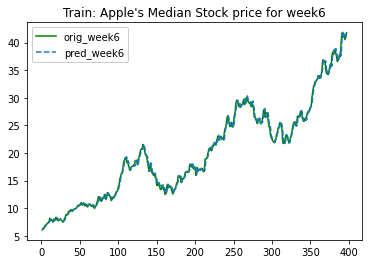

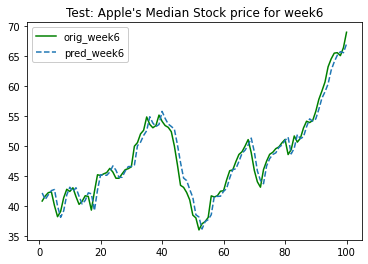

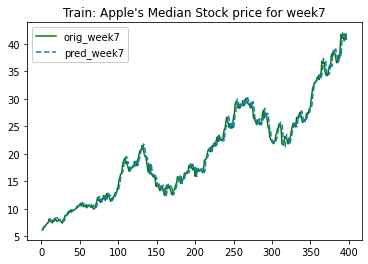

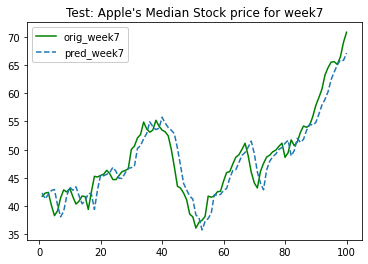

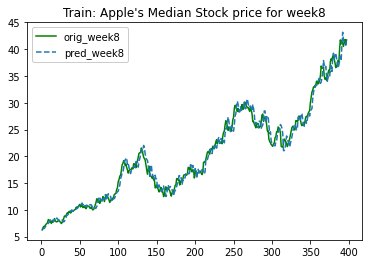

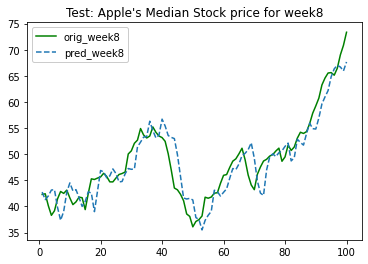

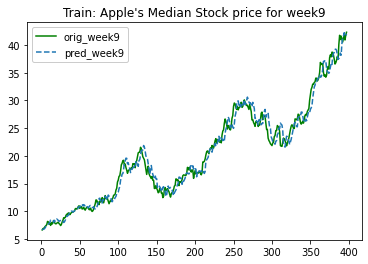

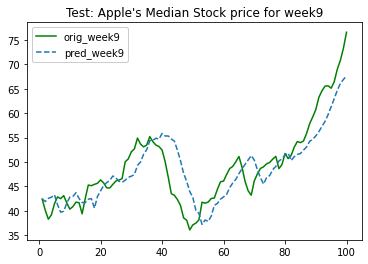

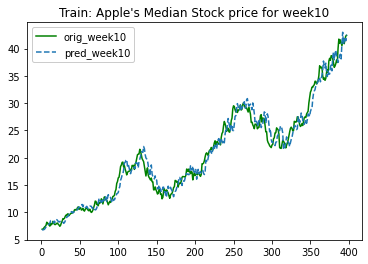

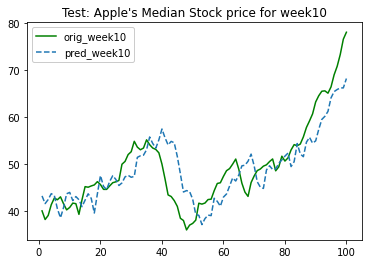

In [67]:
train_pred_y = train_loss()
test_pred_y = test_loss()
for i in range(1, 6):
    plot_train(i, train_y, train_pred_y)
    plot_test(i, test_y, test_pred_y)

In [77]:
data_w6 = {'train_actual': train_y.numpy()[-1,:, 0, 0],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 0]}
w6_data_df = pd.DataFrame(data_w6)

data_w7 = {'train_actual': train_y.numpy()[-1,:, 0, 1],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 1]}
w7_data_df = pd.DataFrame(data_w7)

data_w8 = {'train_actual': train_y.numpy()[-1,:, 0, 2],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 2]}
w8_data_df = pd.DataFrame(data_w8)

data_w9 = {'train_actual': train_y.numpy()[-1,:, 0, 3],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 3]}
w9_data_df = pd.DataFrame(data_w9)

data_w10 = {'train_actual': train_y.numpy()[-1,:, 0, 4],
       'train_predictions': train_pred_y.detach().numpy()[-1, :, 0, 4]}
w10_data_df = pd.DataFrame(data_w10)

In [79]:
print(w6_data_df.head(20))
print(w7_data_df.head(20))
print(w8_data_df.head(20))
print(w9_data_df.head(20))
print(w10_data_df.head(20))

    train_actual  train_predictions
0       6.049106           6.382467
1       6.187098           6.358498
2       6.240301           6.417243
3       6.642778           6.458489
4       6.888709           6.663916
5       6.890396           6.863538
6       7.080826           6.966089
7       7.292260           7.095592
8       7.421818           7.292360
9       7.603969           7.458721
10      8.183534           7.610314
11      8.063482           8.047959
12      7.753154           8.083610
13      7.802984           7.929403
14      7.458158           7.892144
15      7.980841           7.680588
16      7.703169           8.018319
17      7.906170           7.809511
18      8.347130           8.018204
19      7.985592           8.239996
    train_actual  train_predictions
0       6.187098           6.568853
1       6.240301           6.550564
2       6.642778           6.615013
3       6.888709           6.669086
4       6.890396           6.897278
5       7.080826           7

In [22]:
# # Rough for meeting after Sept 9
# # size of the data
# data_size = data_m1.shape[0]
# dim_input = data_m1.shape[1]
# # batch time and batch size
# batch_time = 6  # time steps ahead that we need to predict, for each training sample
# train_size = int(0.8*data_size)  # training size
# print(f"training size is {train_size}")
# test_size = data_size - train_size
# print(f"test size is {test_size}")

# test_freq = 50
# viz = True

# # Convert to tensor
# # https://pytorch.org/docs/stable/generated/torch.from_numpy.html
# data_torch = torch.from_numpy(data_m1)  # https://pytorch.org/docs/stable/generated/torch.from_numpy.html
# # true_y.shape
# # Reshape it to get in (m, 1, dim_input)
# data_torch = torch.reshape(data_torch, (data_size, 1, dim_input))  # https://pytorch.org/docs/stable/generated/torch.reshape.html
# print(data_torch.shape)

# # predictions on test_data's time size (test_size-batch_time, 1)
# # Time steps
# t = torch.linspace(0., test_size-batch_time, test_size-batch_time)
# print(t.shape)

# # Initial value
# true_y0 = torch.reshape(true_y[0:batch_size], (batch_size, 1, dim))
# # true_y0


# def get_batch(mode):
#     if mode == 'train':
#         # Get mini batches
#         s = torch.arange(0, train_size-batch_time)  # https://pytorch.org/docs/stable/generated/torch.arange.html
#         # Get the #s initial values from data 
#         batch_y0 = data_torch[s]  # (M, D): m = number of examples, D = dimension
#         # The time steps ahead for each sample
#         batch_t = t[:batch_time]  # (T)
#         # For each initial value, we will have T values 
#         batch_y = torch.stack([data_torch[s + i] for i in range(0, batch_time)], dim=0)  # (T, M, D)
#         # batch_y = torch.reshape(batch_y, (batch_time, batch_size, 1, 1))
#         return batch_y0, batch_t, batch_y
#     elif mode == 'test':
#         s = torch.arange(train_size, data_size-batch_time)
#         # Get the #s initial values from data 
#         batch_y0 = data_torch[s]  # (M, D): m = number of examples, D = dimension
#         # The time steps ahead for each sample
#         batch_t = t[:batch_time]  # (T)
#         # For each initial value, we will have T values 
#         batch_y = torch.stack([data_torch[s + i] for i in range(0, batch_time)], dim=0)  # (T, M, D)
#         # batch_y = torch.reshape(batch_y, (batch_time, batch_size, 1, 1))
    
#         return batch_y0, batch_t, batch_y

# class ODEFunc(nn.Module):

#     def __init__(self):
#         super(ODEFunc, self).__init__()

#         self.net = nn.Sequential(
#             nn.Linear(dim_input, 150),
#             nn.Tanh(),
#             nn.Linear(150, 50),
#             nn.Tanh(),
#             nn.Linear(50, 50),
#             nn.Tanh(),
#             nn.Linear(50, dim_input),
#         )
#         self.net = self.net.double()
#         for m in self.net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

#     def forward(self, t, y):
#         return self.net(y)
# func = ODEFunc()

# def visualize(t, true_y, pred_y, odefunc, itr):
  
#     if viz:
      
#         plt.figure()
#         plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], 'g-')
#         plt.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--')
#         # plt.savefig(DATA_TYPE + '/ts' + str(itr) + '.png')
#         plt.show()
        
# class RunningAverageMeter(object):
#     """Computes and stores the average and current value"""

#     def __init__(self, momentum=0.99):
#         self.momentum = momentum
#         self.reset()

#     def reset(self):
#         self.val = None
#         self.avg = 0

#     def update(self, val):
#         if self.val is None:
#             self.avg = val
#         else:
#             self.avg = self.avg * self.momentum + val * (1 - self.momentum)
#         self.val = val
# def train_5(optimizer_str, loss_str, niters = niters, print_loss = print_loss):
#     if optimizer_str == 'rmsprop':
#         optimizer = optim.RMSprop(func.parameters(), lr = lr)
#     elif optimizer_str == 'adam':
#         optimizer = optim.Adam(func.parameters(), lr=1e-3)
#     for itr in range(1, niters + 1):
#         optimizer.zero_grad()
#         train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
#         pred_y = odeint(func, train_batch_y0, train_batch_t)
#         # print(pred_y.shape)
#         # loss = torch.mean(torch.abs(pred_y - batch_y))
#         if loss_str == 'mse':
#             loss = torch.nn.MSELoss()(pred_y[:, batch_time-1, :], train_batch_y)  # https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-1-6e439b27117e
#         loss.backward()
#         optimizer.step()
#         if print_loss:
#             if itr%200==0:
#                 with torch.no_grad():
#                     print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))


    
# def train_loss():
#     train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
#     train_pred_y = odeint(func, train_batch_y0, train_batch_t)
#     loss = torch.nn.MSELoss()(train_pred_y[batch_time-1, :, :, :], train_batch_y[batch_time-1, :, :, :])
#     with torch.no_grad():
#         print('Total Train Loss {:.6f}'.format(loss.item()))
#     return train_batch_y, train_pred_y
    

# def test_loss():
#     test_batch_y0, test_batch_t, test_batch_y = get_batch('test')
#     test_pred_y = odeint(func, test_batch_y0, test_batch_t)
#     loss = torch.nn.MSELoss()(test_pred_y[batch_time-1, :, :, :], test_batch_y[batch_time-1, :, :, :])
#     with torch.no_grad():
#         print('Total Test Loss {:.6f}'.format(loss.item()))
#     return test_batch_y, test_pred_y

# def plot_test(i, test_batch_y, test_pred_y):
#     t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
#     plt.figure()
#     plt.plot(t.numpy(), test_batch_y.numpy()[batch_time-1, :, 0, i], 'g', label = f"orig_week{i+batch_time}")
#     plt.plot(t.numpy(), test_pred_y.detach().numpy()[batch_time-1, :, 0, i], '--', label = f"pred_week{i+batch_time}")
#     plt.title(f"Test: Apple's Median Stock price for week{i+batch_time}")
#     plt.legend(framealpha=1, frameon=True);
#     plt.show()
# def plot_train(i, train_batch_y, train_pred_y):
#     t = torch.linspace(1., train_size-batch_time, train_size-batch_time)
#     plt.figure()
#     plt.plot(t.numpy(), train_batch_y.numpy()[batch_time-1, :, 0, i], 'g', label = f"orig_week{i+batch_time}")
#     plt.plot(t.numpy(), train_pred_y.detach().numpy()[batch_time-1, :, 0, i], '--', label = f"pred_week{i+batch_time}")
#     plt.title(f"Train: Apple's Median Stock price for week{i+batch_time}")
#     plt.legend(framealpha=1, frameon=True);
#     plt.show()

# func = ODEFunc()
# lr = 1e-3
# optimizer_str = 'adam'
# niters = 2000  # training epochs
# loss_str = 'mse'
# print_loss = True
# train(optimizer_str, loss_str, niters, print_loss = print_loss)
# train_batch_y, train_pred_y = train_loss()
# test_batch_y, test_pred_y = test_loss()
# for i in range(5):
#     plot_train(i, train_batch_y, train_pred_y)
#     plot_test(i, test_batch_y, test_pred_y)

## Rough for Before Sept 9 meeting

In [4]:
torch.arange(0, train_size-batch_time)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [5]:
torch.arange(train_size, data_size-batch_time)

tensor([401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
        415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
        429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
        443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,
        457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
        471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484,
        485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495])

In [7]:
# s = torch.arange(0, batch_size+0)

In [8]:
# true_y.shape

In [9]:
# true_y[s+5].shape

In [96]:
# torch.reshape(batch_y, (batch_time, batch_size, 1, 1))

In [98]:
# batch_y.shape

In [99]:
# pred_y.shape

In [19]:
# training
ii = 0
func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
# optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
    pred_y = odeint(func, train_batch_y0, train_batch_t)
    # print(pred_y.shape)
    # loss = torch.mean(torch.abs(pred_y - batch_y))
    loss = torch.nn.MSELoss()(pred_y, train_batch_y)  # https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-1-6e439b27117e
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())
    if itr%200==0:
        with torch.no_grad():
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            # visualize(batch_t, batch_y, pred_y, func, ii)

    end = time.time()

Iter 0200 | Total Loss 0.806697
Iter 0400 | Total Loss 0.708462
Iter 0600 | Total Loss 0.653461
Iter 0800 | Total Loss 0.729338
Iter 1000 | Total Loss 0.716897
Iter 1200 | Total Loss 0.557879
Iter 1400 | Total Loss 0.591225
Iter 1600 | Total Loss 0.524499
Iter 1800 | Total Loss 0.663366
Iter 2000 | Total Loss 0.547661


In [29]:
# print training loss
train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
train_pred_y = odeint(func, train_batch_y0, train_batch_t)
loss = torch.nn.MSELoss()(train_pred_y[5, :, :, :], train_batch_y[5, :, :, :])
with torch.no_grad():
    print('Total Loss {:.6f}'.format(loss.item()))

Total Loss 1.409471


In [30]:
# testing
test_batch_y0, test_batch_t, test_batch_y = get_batch('test')
test_pred_y = odeint(func, test_batch_y0, test_batch_t)
loss = torch.nn.MSELoss()(test_pred_y[5, :, :, :], test_batch_y[5, :, :, :])
with torch.no_grad():
    print('Total Loss {:.6f}'.format(loss.item()))

Total Loss 11.852684


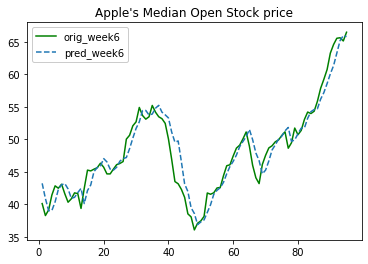

In [34]:
# W6th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 0], 'g', label = 'orig_week6')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 0], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


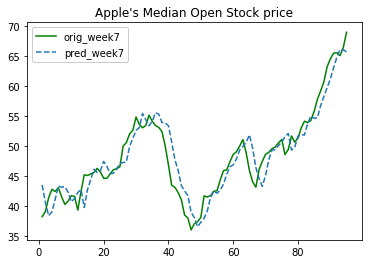

In [39]:
# W7th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 1], 'g', label = 'orig_week7')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 1], '--', label = 'pred_week7')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


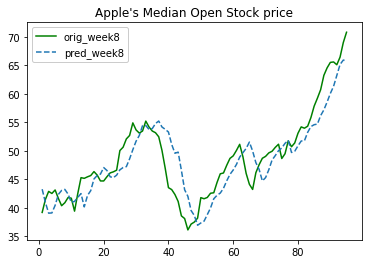

In [40]:
# W8th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 2], 'g', label = 'orig_week8')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 0], '--', label = 'pred_week8')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


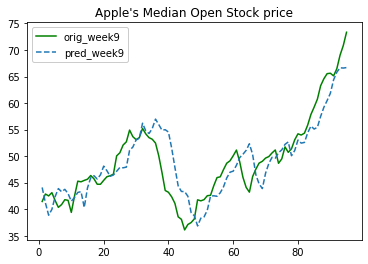

In [41]:
# W9th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 3], 'g', label = 'orig_week9')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 3], '--', label = 'pred_week9')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


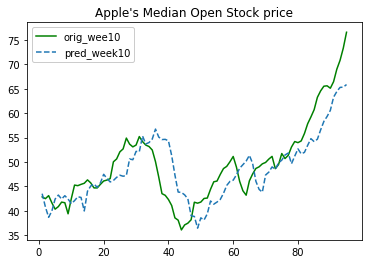

In [42]:
# W10th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 4], 'g', label = 'orig_wee10')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 4], '--', label = 'pred_week10')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


## Adam


In [43]:
# training
ii = 0
func = ODEFunc()
# optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
    pred_y = odeint(func, train_batch_y0, train_batch_t)
    # print(pred_y.shape)
    # loss = torch.mean(torch.abs(pred_y - batch_y))
    loss = torch.nn.MSELoss()(pred_y, train_batch_y)  # https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-1-6e439b27117e
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())
    if itr%200==0:
        with torch.no_grad():
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            # visualize(batch_t, batch_y, pred_y, func, ii)

    end = time.time()

Iter 0200 | Total Loss 0.535809
Iter 0400 | Total Loss 0.510984
Iter 0600 | Total Loss 0.499075
Iter 0800 | Total Loss 0.491926
Iter 1000 | Total Loss 0.483681
Iter 1200 | Total Loss 0.474271
Iter 1400 | Total Loss 0.453295
Iter 1600 | Total Loss 0.438525
Iter 1800 | Total Loss 0.426511
Iter 2000 | Total Loss 0.414654


In [44]:
# print training loss
train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
train_pred_y = odeint(func, train_batch_y0, train_batch_t)
loss = torch.nn.MSELoss()(train_pred_y[5, :, :, :], train_batch_y[5, :, :, :])
with torch.no_grad():
    print('Total Loss {:.6f}'.format(loss.item()))

# testing
test_batch_y0, test_batch_t, test_batch_y = get_batch('test')
test_pred_y = odeint(func, test_batch_y0, test_batch_t)
loss = torch.nn.MSELoss()(test_pred_y[5, :, :, :], test_batch_y[5, :, :, :])
with torch.no_grad():
    print('Total Loss {:.6f}'.format(loss.item()))

Total Loss 1.081104
Total Loss 12.245694


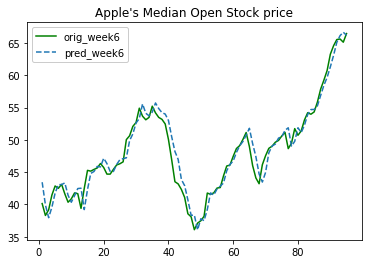

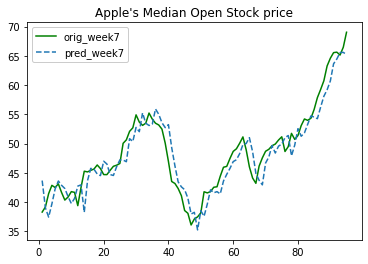

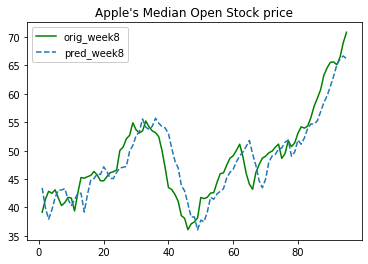

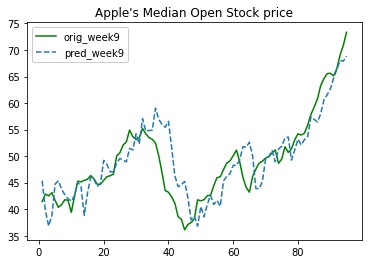

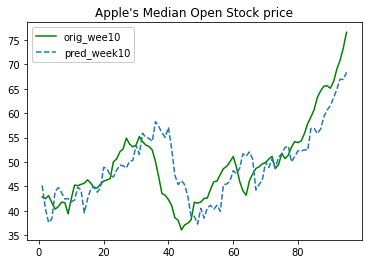

In [45]:
# W6th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 0], 'g', label = 'orig_week6')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 0], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W7th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 1], 'g', label = 'orig_week7')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 1], '--', label = 'pred_week7')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W8th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 2], 'g', label = 'orig_week8')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 2], '--', label = 'pred_week8')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W9th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 3], 'g', label = 'orig_week9')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 3], '--', label = 'pred_week9')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W10th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 4], 'g', label = 'orig_wee10')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 4], '--', label = 'pred_week10')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


In [3]:
# importing libraries
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from torchdiffeq import odeint, odeint_adjoint
from stockDataTransformer import stockDataTransformer

# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)

# Total Data Size
data_size = data.shape[0]

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

median_data = get_median(data)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))

# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, 5, 5).values
print(data_m1.shape)
# columns = ['week(t-4)', 'week(t-3)', 'week(t-2)', 'week(t-1)', 'week(t)']
print(pd.DataFrame(data_m1).head(20))

(506, 1)
   median_stockprice_week
0                6.522572
1                6.432569
2                6.384427
3                6.225123
4                5.997283
5                6.049106
6                6.187098
7                6.240301
8                6.642778
9                6.888709
(497, 10)
           0         1         2         3         4         5         6  \
0   6.522572  6.432569  6.384427  6.225123  5.997283  6.049106  6.187098   
1   6.432569  6.384427  6.225123  5.997283  6.049106  6.187098  6.240301   
2   6.384427  6.225123  5.997283  6.049106  6.187098  6.240301  6.642778   
3   6.225123  5.997283  6.049106  6.187098  6.240301  6.642778  6.888709   
4   5.997283  6.049106  6.187098  6.240301  6.642778  6.888709  6.890396   
5   6.049106  6.187098  6.240301  6.642778  6.888709  6.890396  7.080826   
6   6.187098  6.240301  6.642778  6.888709  6.890396  7.080826  7.292260   
7   6.240301  6.642778  6.888709  6.890396  7.080826  7.292260  7.421818   
8   6.64277